In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import supervision as sv
from tqdm.notebook import tqdm
import cv2
from autodistill.detection import CaptionOntology
from autodistill_yolov8 import YOLOv8

In [112]:
# funcion para crear una carpeta dentro de un directorio si no existe
import os
import shutil

def crear_carpeta(directorio, nombre=None):
    if nombre !=None:
        directorio = os.path.join(directorio, nombre)
    if not os.path.exists(directorio):
        os.mkdir(directorio)
    return directorio

# funcion para crear un archivo .txt de labels

def inferir_y_guardar(image_paths, model, imag_folder, label_folder, confidence=0.7, ):
    for image_path in image_paths:
        results=model.predict(image_path, confidence=confidence)
        # salvar imagen en train_images_folder
        image_name = os.path.basename(image_path)
        shutil.copy(image_path, imag_folder)

        # crear un txt para almacenar las labels de la imagen
        txt_name = image_name.replace(".jpg", ".txt")
        txt_path = os.path.join(label_folder, txt_name)
        with open(txt_path, "a") as f:
            label = results[0].boxes.cls
            coordenadas = results[0].boxes.xywhn
            for lab, (x, y, w, h) in zip(label, coordenadas):                    
                f.write("{} {} {} {} {}\n".format(int(lab), x, y, w, h))
    return results[0].names
     
   


In [111]:
model = YOLOv8("./train_models/yolo8n_4cam_100epochs.pt")
results=model.predict("./images/entrada_salida", confidence=0.7) # /A15_20230904115956-00014.jpg
len(results[0].names)



image 1/4 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00014.jpg: 576x704 13 persons, 168.1ms
image 2/4 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00018.jpg: 576x704 12 persons, 134.4ms
image 3/4 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00020.jpg: 576x704 4 persons, 133.9ms
image 4/4 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00024.jpg: 576x704 4 persons, 129.4ms
Speed: 4.0ms preprocess, 141.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 704)


1

In [101]:
label=results[0].boxes.cls
coordenadas=results[0].boxes.xywhn
for lab, (x, y, w, h) in zip(label, coordenadas): 
    print(lab,x,y,w,h)

tensor(0.) tensor(0.6361) tensor(0.7605) tensor(0.0845) tensor(0.3773)
tensor(0.) tensor(0.3906) tensor(0.4297) tensor(0.0581) tensor(0.2341)
tensor(0.) tensor(0.5236) tensor(0.7954) tensor(0.0876) tensor(0.3259)
tensor(0.) tensor(0.5387) tensor(0.4676) tensor(0.0644) tensor(0.2093)
tensor(0.) tensor(0.7438) tensor(0.6805) tensor(0.1009) tensor(0.2200)
tensor(0.) tensor(0.5298) tensor(0.3370) tensor(0.0480) tensor(0.1420)
tensor(0.) tensor(0.5677) tensor(0.2542) tensor(0.0340) tensor(0.1902)
tensor(0.) tensor(0.5696) tensor(0.0989) tensor(0.0246) tensor(0.1252)
tensor(0.) tensor(0.5274) tensor(0.6417) tensor(0.0740) tensor(0.1464)
tensor(0.) tensor(0.7882) tensor(0.5290) tensor(0.0506) tensor(0.2134)
tensor(0.) tensor(0.1994) tensor(0.6818) tensor(0.0702) tensor(0.2436)
tensor(0.) tensor(0.4515) tensor(0.1180) tensor(0.0312) tensor(0.1300)
tensor(0.) tensor(0.5300) tensor(0.1849) tensor(0.0345) tensor(0.1116)


In [115]:
import os
import glob
import random
import yaml

def label_multiple_yolov8(
    model_path,
    input_folder: str,
    output_folder: str = None,
    confidence= 0.7,):
    
    #hacer una lista de todos los path de imagenes en el directorio input_folder
    glob_path = os.path.join(input_folder, "*.jpg")
    image_paths = glob.glob(glob_path)
    modelyolo= YOLOv8(model_path)

    # hacer una particion aleatoria 80 - 20 de la lista de imagenes
    train_images = random.sample(image_paths, int(0.8 * len(image_paths)))
    valid_images = list(set(image_paths) - set(train_images))

    # crear un directorio de salida si no existe
    crear_carpeta(output_folder)
    train = crear_carpeta(output_folder, "train")
    valid = crear_carpeta(output_folder, "valid")
    train_images_folder = crear_carpeta(train, "images")
    train_labels_folder  = crear_carpeta(train, "labels")
    valid_images_folder = crear_carpeta(valid, "images")
    valid_labels_folder  = crear_carpeta(valid, "labels") 
            
    train_names=inferir_y_guardar(train_images, modelyolo, train_images_folder, train_labels_folder, confidence, )
    inferir_y_guardar(valid_images, modelyolo, valid_images_folder, valid_labels_folder, confidence, )

    print(train_names)
    # Definir otras variables
    nc = len(train_names)
    data = {
    "names": list(train_names.values()),
    "nc": nc,
    "train": train,
    "val": valid
    }

    # Escribir el diccionario en un archivo YAML
    yaml_path = os.path.join(output_folder,"data.yaml")
    with open(yaml_path, "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)



In [117]:
label_multiple_yolov8(
    model_path="./train_models/yolo8n_4cam_100epochs.pt", 
    input_folder="./images/entrada_salida",
    output_folder="./dataset/data1",
    )


image 1/1 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00024.jpg: 576x704 4 persons, 215.2ms
Speed: 3.0ms preprocess, 215.2ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 704)

image 1/1 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00014.jpg: 576x704 13 persons, 143.5ms
Speed: 3.0ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 704)

image 1/1 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00020.jpg: 576x704 4 persons, 131.1ms
Speed: 4.0ms preprocess, 131.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 704)

image 1/1 d:\Alexander\Go2Future\Autolabel_roboflow\images\entrada_salida\A15_20230904115956-00018.jpg: 576x704 12 persons, 139.7ms
Speed: 3.0ms preprocess, 139.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 704)


{0: 'person'}


In [46]:
print(image_paths)

['./images/entrada_salida\\A15_20230904115956-00014.jpg', './images/entrada_salida\\A15_20230904115956-00018.jpg', './images/entrada_salida\\A15_20230904115956-00020.jpg', './images/entrada_salida\\A15_20230904115956-00024.jpg']


In [4]:
# Crear el directorio "images" dentro del directorio actual si no existe
images_dir = os.path.join(HOME, "images")

if not os.path.exists(images_dir):
    os.mkdir(images_dir)

# Crear el directorio "videos" dentro del directorio actual si no existe
images_dir = os.path.join(HOME, "videos")

if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [5]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 400

## Dividir los videos en imágenes

In [7]:

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:1], video_paths

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.jpg"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 22


In [9]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

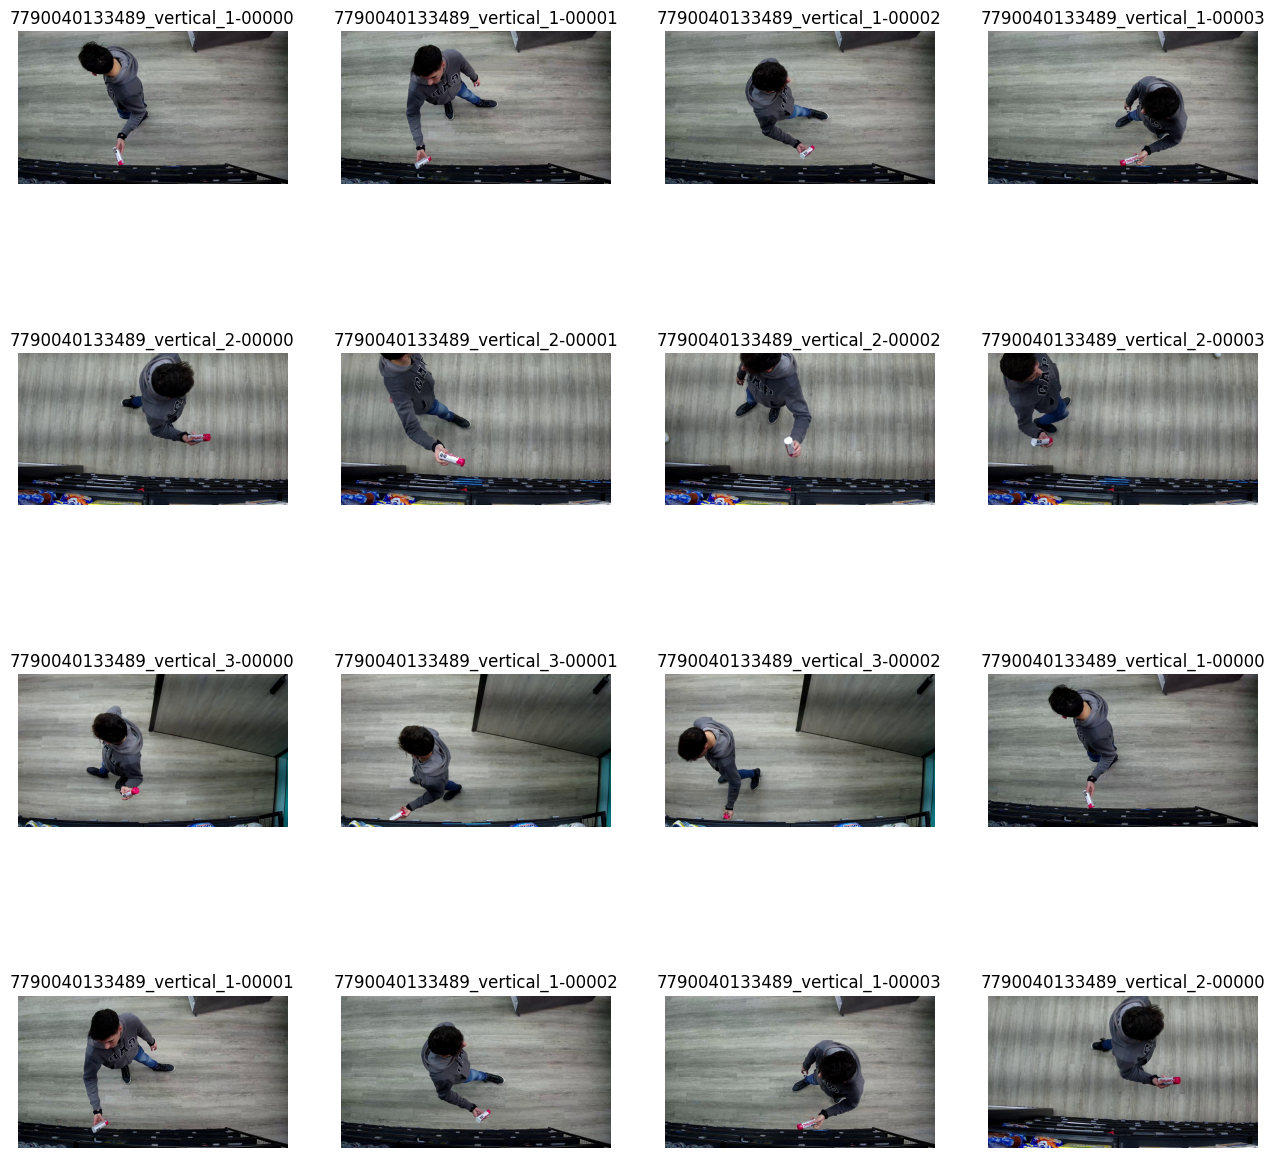

In [10]:
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Generar prompt para determinar que queremos que el modelo detecte

In [16]:
ontology = CaptionOntology({"product held by": "7622210723468",
  "hands with":"hand"})

## Initiate base model and autolabel

In [12]:
DATASET_DIR_PATH = f"{HOME}/dataset"

### Grounded SAM

In [ ]:
from autodistill_grounded_sam import GroundedSAM

# load the model
base_model = GroundedSAM(ontology=ontology)


In [ ]:
# label all images in a folder called `context_images`
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

### Grounded OWL ViT

In [18]:
from autodistill_owl_vit import OWLViT

# load the model
base_vit = OWLViT(
    ontology=ontology,
    #box_threshold=0.35, 
    #text_threshold=0.25
    )

In [19]:
# label all images in a folder called `context_images`
dataset = base_vit.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

Labeling d:\Alexander\Go2Future\Autolabel_roboflow/images\7790040133489_vertical_1-00000.jpg:   0%|          | 0/11 [00:00<?, ?it/s]d:\Alexander\Go2Future\Autolabel_roboflow\.venv\Lib\site-packages\transformers\models\owlvit\image_processing_owlvit.py:355: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(
Labeling d:\Alexander\Go2Future\Autolabel_roboflow/images\7790040133489_vertical_3-00002.jpg: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Labeled dataset created - ready for distillation.


### Grounded DINO

In [8]:
from autodistill_grounding_dino import GroundingDINO
# load the model
base_model = GroundingDINO(
    ontology=ontology,
    box_threshold=0.35, 
    text_threshold=0.25)

trying to load grounding dino directly


d:\Alexander\Go2Future\Autolabel_roboflow\.venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [103]:
# label all images in a folder called `context_images`
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

Labeling d:\Alexander\Go2Future\Autolabel_roboflow/images\7790040133488_vertical_3-00004.jpg: 100%|██████████| 9/9 [04:05<00:00, 27.23s/it]


Labeled dataset created - ready for distillation.


In [22]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [23]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

8

In [6]:
ANNOTATIONS_DIRECTORY_PATH2 = f"{HOME}/dataset/7790040133489/train/labels"
IMAGES_DIRECTORY_PATH2 = f"{HOME}/dataset/7790040133489/train/images"
DATA_YAML_PATH2 = f"{HOME}/dataset/7790040133489/data.yaml"

In [7]:
dataset2 = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH2,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH2,
    data_yaml_path=DATA_YAML_PATH2)

len(dataset)

11

In [28]:
from src.util import merge_datasets
from src import config

# Paths to individual datasets
folders=os.listdir(config.DATASET_DIR_PATH)
# get all full folder path into the folder Dataset
dataset_paths=[os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]

output_path = os.path.join(config.DATASET_DIR_PATH, "Merge_Dataset")
merge_datasets(dataset_paths, output_path)


In [31]:
ANNOTATIONS_DIRECTORY_PATH2 = f"{HOME}/dataset/Merge_Dataset/train/labels"
IMAGES_DIRECTORY_PATH2 = f"{HOME}/dataset/Merge_Dataset/train/images"
DATA_YAML_PATH2 = f"{HOME}/dataset/Merge_Dataset/data.yaml"

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH2,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH2,
    data_yaml_path=DATA_YAML_PATH2)

len(dataset)

22

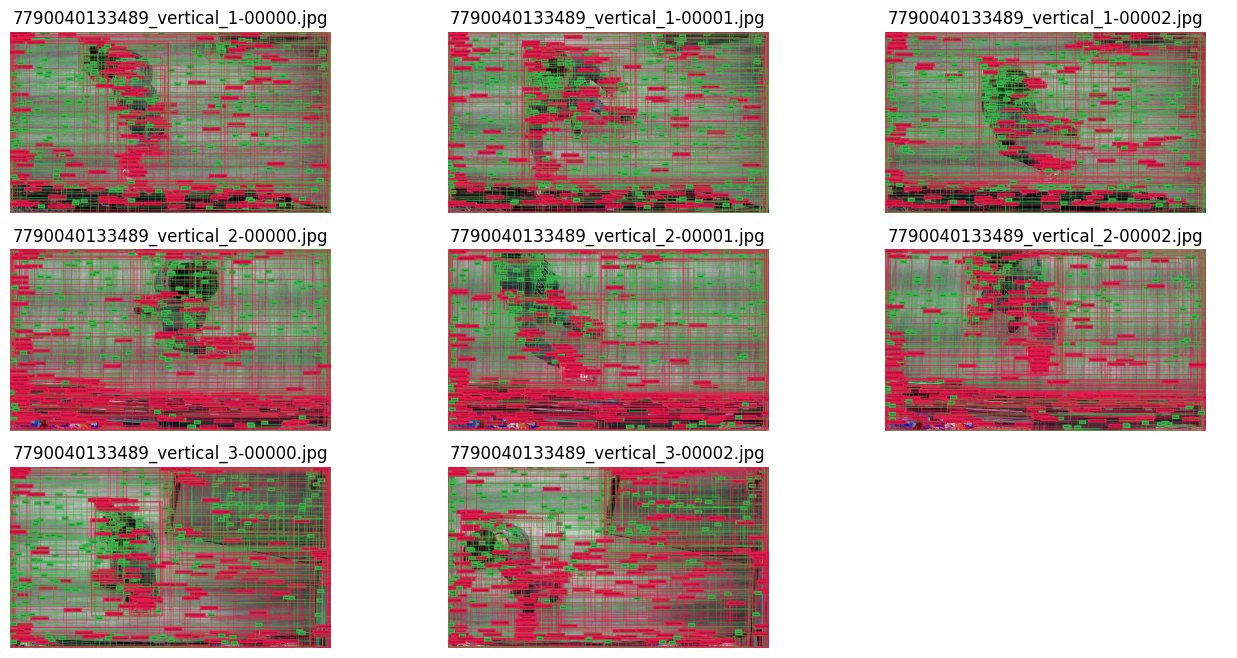

In [24]:
SAMPLE_SIZE = 8
SAMPLE_GRID_SIZE = (3, 3)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
imag_alone_path=f"{HOME}/images/7790040133488_vertical_1-00004.jpg"

detections = base_model.predict(imag_alone_path)
image=cv2.imread(str(imag_alone_path))

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=detections)

annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=detections,
        labels=["product"]
        )
        
%matplotlib inline  
sv.plot_image(annotates_image, (16, 16))

In [22]:
base_model.ontology=CaptionOntology({"hand":"hand"})
